## 2020-5-11 

Analysis by Jeremy Mann

In these notes, we wrangle the each image csv into a single xarray DataArray (or a dataset).

### Grey-scale images:
Dimensions: 3
Shape: (num_of_samples, pixel_width, pixel_height, one_hot_encoded_categories)

### Color images:

Dimensions: 3
Shape: (num_of_samples, pixel_width, pixel_height, one_hot_encoded_categories)
Coordinates: color coordinates: ['R', 'G', 'B']

c

Initially I was going to record the px/length ratio as coordinates in the xarray, but I feel uncomfortable by the differences in sizes between each image type, including the "rawer" images from the containing the "image_tiles" and "larger_images'. 



In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

## Primary Wranglers;

1. Split each data set into train and test set. 
1. Make the image array
    1. X_\<resolution>_train
    1. X_\<resolution>_test
1. Make the label array 
    1. Y_\<resolution>_train
    1. X_\<resolution>\_test
1. Save image data as a netcdf file
1. Save label data

In [3]:
def gs_images_to_xarray(X):
    res = int(np.sqrt(X.shape[1]))
    images = X.reshape(-1, res, res)
    xr_images = xr.DataArray(data=images, dims=["sample", "x", "y"])
    return xr_images

In [4]:
def rgb_images_to_xarray(X):
    res = int(np.sqrt(X.shape[1]/3))
    rgb_images = X.reshape(-1, res, res, 3)
    color_coords = ["Red", "Green", "Blue"]
    xr_rgb_images = xr.DataArray(
        data=rgb_images,
        dims=["sample", "x", "y", "color"],
        coords={"color": color_coords},
    )
    return xr_rgb_images

In [5]:
def labels_to_xarray(y, fitted_encoder):
    labels = fitted_encoder.transform(y) 
    label_coords = [
        "Tumor",
        "Stroma",
        "Complex",
        "Lympho",
        "Debris",
        "Mucosa",
        "Adipose",
        "Empty",
    ]
    dims = ["sample", "label"]
    xrlabel = xr.DataArray(
        data=labels #, dims=dims, #coords={"label": label_coords}
    )
    return xrlabel

In [6]:
def save_wrangle_data(filepath, color_type):
    data = pd.read_csv(filepath).values
    X = data[:, :-1]
    y = data[:, -1].reshape(-1, 1)
    encoder = OneHotEncoder(sparse = False).fit(y)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y)

    if color_type == "RGB":
        res = str(int(np.sqrt(X_train.shape[1]/3)))
        X_clean_train = rgb_images_to_xarray(X_train)
        X_clean_test = rgb_images_to_xarray(X_test)
    else:
        res = str(int(np.sqrt(X_train.shape[1])))
        X_clean_train = gs_images_to_xarray(X_train)
        X_clean_test = gs_images_to_xarray(X_test)

    y_clean_train = labels_to_xarray(y_train, encoder)
    y_clean_test = labels_to_xarray(y_test, encoder)
        
    descriptor = res + '_' + color_type
    
    X_clean_train.to_netcdf("X_" + descriptor + "_clean_train.nc")
    X_clean_test.to_netcdf("X_" + descriptor + "_clean_test.nc")
    y_clean_train.to_netcdf("y_" + descriptor + "_clean_train.nc")
    y_clean_test.to_netcdf("y_" + descriptor + "_clean_test.nc")

    return

In [7]:
direc_path = '/Users/jeremymann/Documents/data-science-projects/crc-dl-tda-project/data/colorectal-histology-mnist/'
grey_filenames = ['hmnist_8_8_L.csv', 'hmnist_28_28_L.csv',  'hmnist_64_64_L.csv']
color_filenames = ['hmnist_8_8_RGB.csv', 'hmnist_8_8_RGB.csv']

for name in grey_filenames:
    save_wrangle_data(direc_path + name, 'L')
for name in color_filenames:
    save_wrangle_data(direc_path + name, 'RGB')

In [244]:
A = xr.load_dataarray('/Users/jeremymann/Documents/data-science-projects/crc-dl-tda-project/data/clean_data/X_28_RGB_clean_test.nc')

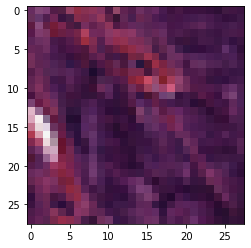

In [251]:
plt.imshow(A[1019,:,:,:])

# Sanity Check Test:

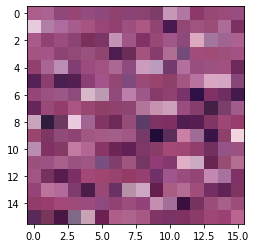

In [88]:
rgb_28_filepath = 'Documents/data-science-projects/crc-dl-tda-project/data/colorectal-histology-mnist/hmnist_28_28_RGB.csv'
X_train, X_test, y_train, y_test = train_test_split_csv(filepath)
plt.imshow(rgb_images_to_xarray(X_train)[1000, :, :, :])